# Car Overtaking
In this task, you will design a nonlinear MPC on a kinematic bicycle car model to overtake the leading vehicle.

You will need to complete the **nmpc_controller()** function to provide the solver for Casadi NMPC implementation. 

# System model

We assume the leading vehicle is cruising with velocity $\bar{v}_x$ along the center of a straight lane. Let the left hand side of the driving direction be the positive direction of $y$ and the $y$ position of leading vehicle as $0$. The yaw angle of the leading vehicle is $0$. 

The state of the ego vehicle is defined as the position with respect to the leading car $\left[x, y\right]$, yaw angle $\psi$, and the velocity $v$. The vehicle is controlled by the steering angle of front wheel $\delta$ and the acceleration $a$.

Thus, the dynamics of the vehicle can be expressed as:

$$
\frac{d}{dt} \begin{bmatrix} x \\ y \\ \psi \\ v \end{bmatrix}
= \begin{bmatrix} v\cos(\psi + \beta) - \bar{v}_x \\
                  v\sin(\psi + \beta)\\
                  \frac{v}{L_r} \sin\beta \\
                  a
  \end{bmatrix}, \text{with } \beta := \arctan(\frac{L_r}{L_r + L_f} \arctan \delta).
$$

where $L_r = L_f = 1.0$ is distance from the rear or front axles to the center of the vehicle. 

We apply the explicit Euler integration to obtain the discrete-time dynamics model of $\dot{s}=f(s, u) \ \ \text{as}\ \ s_{k+1} = s_{k} + f(s_k, u_k) \Delta t$. The state of the vehicle is $$s:=[x, y, \psi, v]^\top.$$

with control input:
$$
u:=[a, \delta]^\top. 
$$

In this task, we assume $\Delta t = 0.1 ~s$ in both simulation and controller design.


<div>
<img src="takeover.png" width="800" align="left"/>
</div>

# Controller design:

You ara supposed to design an MPC controller of the following form to takeover the leading vehicle with desired velocity and go back to the same lane as the leading vehicle.

$
\begin{equation}
    \begin{aligned}
    \min_{s_k, u_k} & \ C1_{N} + C2_{N} + C3_{N} + \sum_{k=0}^{N-1} C1_{k} + C2_{k} + C3_{k} + C4_{k} \\ 
    \text{s.t. } & s_{k+1} = s_{k} + f(s_k, u_k) \Delta t, \ k = 0, \dots, N-1, \\
                 & Cons1_k, Cons2_k, Cons3_k, Cons4_k, \\
                 & s_0 = s_{init}.
    \end{aligned}
\end{equation}
$

## Cost function:
C1: Track a desired longitudinal velocity.

C2: Regularize the lateral velocity and yaw rate.

C3: Encourage the car to stay at the same lane as the leading vehicle. 

C4: Regularize the control inputs. 

**Hints**: How do we achieve these goals in LQR controller? 


## Constraints:

#### Cons1: Collision avoidance:
We consider a elliposoidal safety set for the vehicle when overtaking the car

$(\frac{x_k}{r_x})^2 + (\frac{y_k}{r_y})^2 - 1 \ge 0 $, 

We assign $r_x = 30 ~m, r_y = 2 ~m$.

#### Cons1: Maximum lateral acceleration
We restrict the lateral acceleration $a_y$ by:
$|a_y| \le 0.5 \mu g $, where $\mu$ is the coefficient of friction and $g$ is the gravity. 

**Hint**: The leteral acceleration is $ a_y = v \dot{\psi}$. 

**Hint**: $\dot{\psi}_{k} h = \psi_{k+1} - \psi_k $

We assume $\mu = 0.6$ and $g = 9.81 ~m / s^2$.

#### Cons2: Lane keeping
We restrict the car to only overtake using the left lane and do not cross the right lane (recommended in real driving too!).

$y_R \le y \le y_L$

We assume $y_L = 3m$ and $y_R = -1m$.

#### Cons3: Steering rate ####
The steering angle of the vehicle can not change too fast:

<!-- $|\delta_{k+1} - \delta_{k}| \le |\dot{\delta}|_{\max} \Delta t $ -->
$\|\dot{\delta}\| \le |\dot{\delta}|_{max} = 0.6 ~\text{rad}/s$. 

**Hint**: $\dot{\delta}_{k} h = \delta_{k+1} - \delta_k $


#### Cons4: Input bounds
The input is within the bounds:

$-10 ~m/s^2 = a_{\min} \le a \le a_{\max} = 4 ~m / s^2$

$-0.6 \text{rad} = \delta_{\min} \le \delta \le \delta_{\max} = 0.6 \text{rad} $

# Submission detail

### Controller input
The autograder will provide the initial condition of the state, longitudinal velocity of leader car, desired longitudinal speed and the steering angle from the last step. 

### Controller output
You are supposed to complete the **nmpc_controller** in **nmpc_takeover_student.py**, which will return an instance of the nonlinear programming problem, the planning horizon, shapes of the varaibles, and bounds. 

### Evaluation

We will score the controller based on the violation of all the constraints and if overtaking is successful. 

In [ ]:
import casadi as ca
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

In [ ]:
%load_ext autoreload
%autoreload 2
from nmpc_takeover_student import *
# from nmpc_takeover_gsi import *
from utils import *

In [15]:
# Initial test case
x_init = np.array([-35., # x: x distance between our car and leader car
                0.0, # y: y distance between our car and leader car
                0.0, # yaw: yaw angle of our car
                60., # v: velocity of our car
                15., # v_x_leader: x velocity of leader car
                0.0, # v_y_leader: y velocity of leader car, fixed as 0. 
                55.0 # v_x_desired: desired takeover x velocity of our car
                ])      
xt, ut = eval_controller(x_init)


Total number of variables............................:      604
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      604
                     variables with only upper bounds:        0
Total number of equality constraints.................:      404
Total number of inequality constraints...............:      700
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      700
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.1976836619341889e+03    1.7504617096280679e+03
Dual infeasibility......:   6.6354985158164026e-13    9.6980416827867906e-13
Constraint violation....:   2.2737367544323206e-13    2.2737367544323206e-13
Variable bound violation:   3.9964047182650120e-08    3.9964047182650120e-08
Complementarit

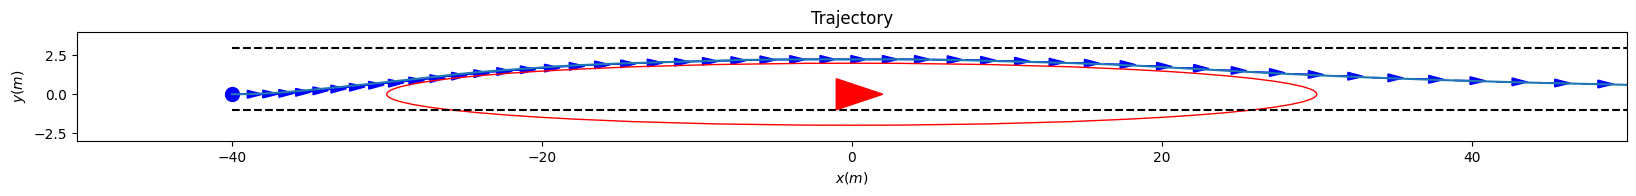

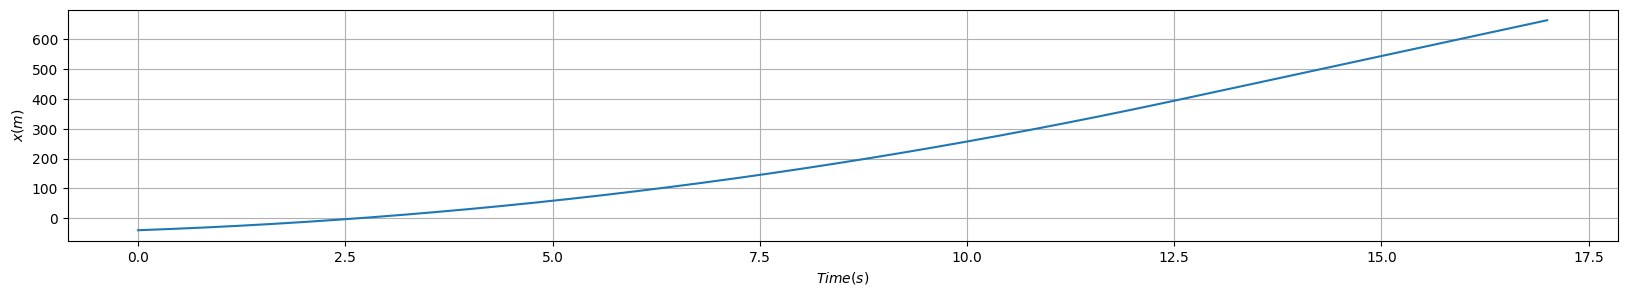

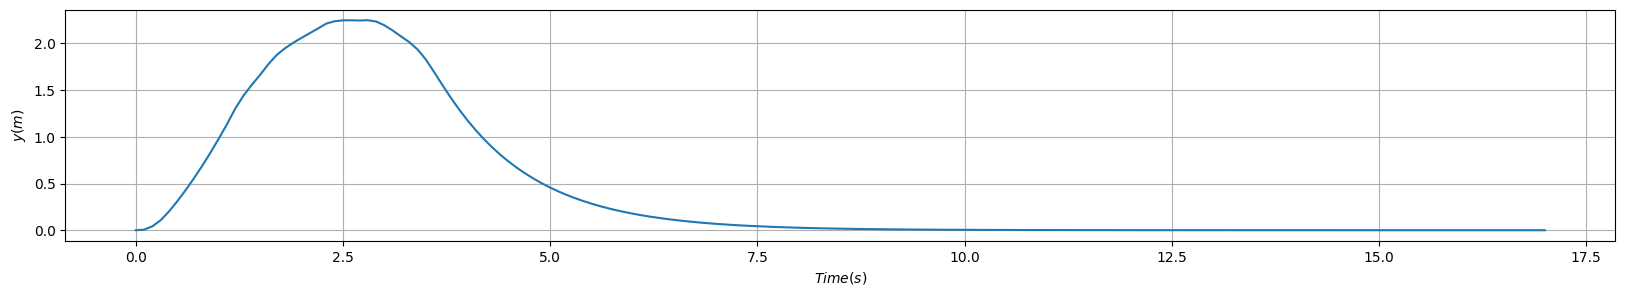

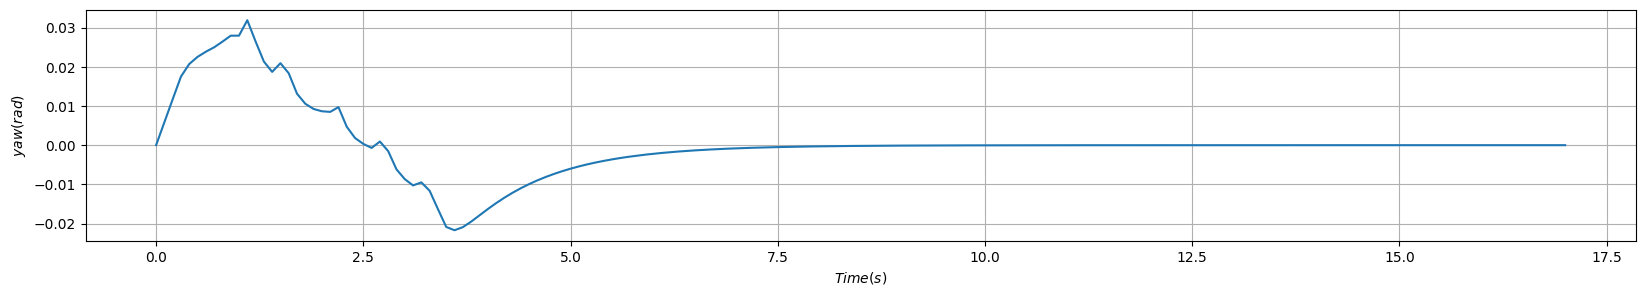

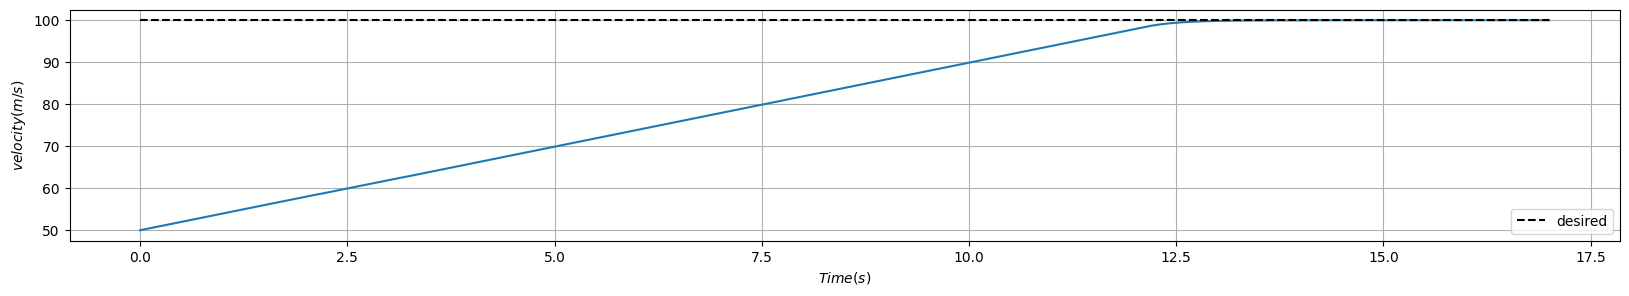

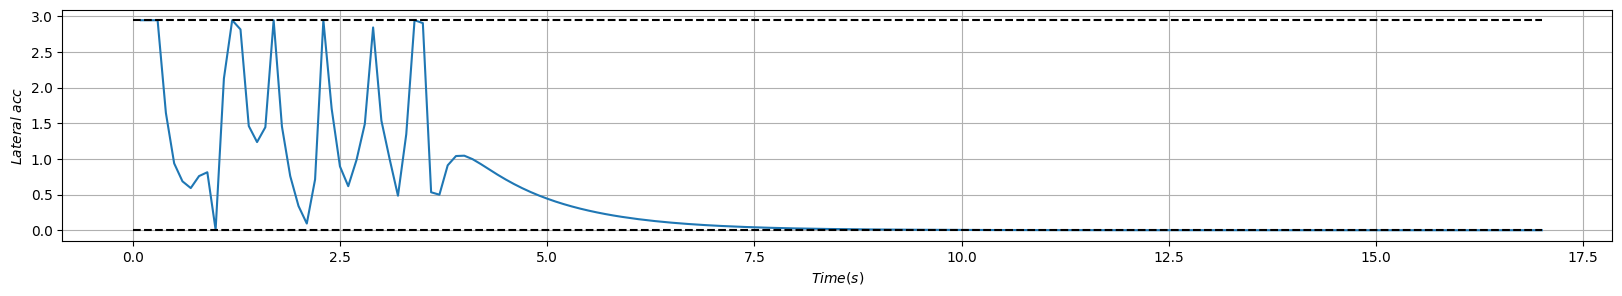

In [16]:
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon


### Maximum lateral acceleration ###
h = 0.1
gmu = 0.5 * 0.6 * 9.81
dx = (xt[1:, :] - xt[0:-1, :]) / h
ay = dx[:, 2] * xt[0:-1, 3]# dx[:, 3]
ay = np.abs(ay) - gmu



### Plot trajectory ###
x_w = xt[:, 0]
y_w = xt[:, 1]
yaw = xt[:, 2]
x0 = np.expand_dims(x_w, 1)
y0 = np.expand_dims(y_w, 1)
yaw = np.expand_dims(yaw, 1)
dx, dy = np.cos(yaw), np.sin(yaw)
arrows = np.concatenate((x0, y0, dx, dy), axis=1)[0:50, :]
fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(x_w[0], y_w[0], "b.", markersize = 20)
for arrow in arrows:
    ax.arrow(arrow[0], arrow[1], arrow[2], arrow[3], head_width=0.5, head_length=1, fc='blue', ec='blue')
ax.plot(x_w, y_w)
ax.axis("scaled")
plt.title("Trajectory")
plt.xlabel("$x(m)$")
plt.ylabel("$y(m)$")
plt.xlim((-50, 50))
plt.ylim((-3, 4))
# Define ellipse parameters
center_x = 0
center_y = 0
width = 60
height = 4
color = 'red'
fill = False
# Create an Ellipse object
ellipse = Ellipse((center_x, center_y), width, height, color=color, fill=fill)
# Add the ellipse to the axis
ax.add_patch(ellipse)
# Define the vertices of the triangle as a list of (x, y) coordinates
vertices = [(2, 0), (-1, 1), (-1, -1)]
# Create a Polygon patch using the vertices and add it to the axis
triangle = Polygon(vertices, closed=True, fill=True, color='r')
ax.add_patch(triangle)
# y constrain
plt.plot(x_w, 3*np.ones(x_w.shape), "--", color='black')
plt.plot(x_w, -1*np.ones(x_w.shape), "--", color='black')
plt.show()



### Plot x-t figure ###
t = np.linspace(0, 17, 171)
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 0])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$x(m)$")
plt.show()



### Plot y-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 1])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$y(m)$")
plt.show()



### Plot yaw-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 2])
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$yaw(rad)$")
plt.show()



### Plot v-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t, xt[:, 3])
plt.plot(t, t*0 + x_init[-1], "k--", label = "desired")
plt.legend()
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$velocity(m/s)$")
plt.show()



### Plot a-t figure ###
plt.figure(figsize=(20, 3))
plt.plot(t[1:], ay + (0.5 * 0.6 * 9.81))
plt.grid()
plt.xlabel("$Time(s)$")
plt.ylabel("$Lateral\ acc$")
plt.plot(t, np.ones(t.shape)*0.5*0.6*9.81, 'k--')
plt.plot(t, -np.zeros(t.shape), 'k--')
plt.show()